# Validation of other estimation methods for omega
- In this report, we try to estimate omega in a different way from the original paper and check AA-test result.
- The `omega` is the weight of features (donor pull) in Synthetic Control Methods.
- The classical Synthetic Control Methods (ADH) restrictions the following:
    - non-negativity of weights
    - summing to one
    - no intercept
- In the original paper, intercept is allowed for this. (It also incorporates the L2 regularization term into the loss function.)

## Additional methods for PySynthDID
### (1) Search zeta by cross validation
- `zeta` is a hyper-parameter in the estimation of `omega`
- In the original paper, theoretical values were used for zeta.
- In this note, we do not use this theoretical value, but perform cross-validation in the pre-intervention period and compare and discuss the results.
    - Grid Search
    - Baysian Optimaization

### (2) Significant relaxation of ADH conditions
- While the ADH condition is very good in terms of interpretability, it does not seem to be particularly necessary mathematically.
- Here, we relax the `sum(w)=1 condition` and the `non-negative constraint`. Specifically, we adopt Lasso, Rige, and ElasticNet, and after performing CV, we adopt the coefficients of sparse regression as `omega`

In [1]:
import warnings

warnings.filterwarnings("ignore")

import sys
import os

sys.path.append(os.path.abspath("../"))

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
plt.style.use('ggplot')

from tqdm import tqdm

from synthdid.model import SynthDID
from synthdid.sample_data import fetch_CaliforniaSmoking

In [2]:
df = fetch_CaliforniaSmoking()

PRE_TEREM = [1970, 1988]
POST_TEREM = [1989, 2000]

TREATMENT = ["California"]

df.head()

,Alabama,Arkansas,Colorado,Connecticut,Delaware,Georgia,Idaho,Illinois,Indiana,Iowa,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,West Virginia,Wisconsin,Wyoming,California
1970,89.800003,100.300003,124.800003,120.000000,155.000000,109.900002,102.400002,124.800003,134.600006,108.500000,...,92.699997,99.800003,106.400002,65.500000,122.599998,124.300003,114.500000,106.400002,132.199997,123.000000
1971,95.400002,104.099998,125.500000,117.599998,161.100006,115.699997,108.500000,125.599998,139.300003,108.400002,...,96.699997,106.300003,108.900002,67.699997,124.400002,128.399994,111.500000,105.400002,131.699997,121.000000
1972,101.099998,103.900002,134.300003,110.800003,156.300003,117.000000,126.099998,126.599998,149.199997,109.400002,...,103.000000,111.500000,108.599998,71.300003,138.000000,137.000000,117.500000,108.800003,140.000000,123.500000
1973,102.900002,108.000000,137.899994,109.300003,154.699997,119.800003,121.800003,124.400002,156.000000,110.599998,...,103.500000,109.699997,110.400002,72.699997,146.800003,143.100006,116.599998,109.500000,141.199997,124.400002
1974,108.199997,109.699997,132.800003,112.400002,151.300003,123.699997,125.599998,131.899994,159.600006,116.099998,...,108.400002,114.800003,114.699997,75.599998,151.800003,149.600006,119.900002,111.800003,145.800003,126.699997


In [3]:
sdid = SynthDID(df, PRE_TEREM, POST_TEREM, TREATMENT)
sdid.fit(zeta_type="base", sparce_estimation=True)

In [4]:
# eg.
sdid.estimated_params(model="ElasticNet")

,features,ElasticNet_weight
0,Alabama,-0.000
1,Arkansas,-0.000
2,Colorado,0.063
3,Connecticut,0.120
4,Delaware,0.000
5,Georgia,-0.000
6,Idaho,0.000
7,Illinois,0.203
8,Indiana,-0.000
9,Iowa,0.000


## (1) Search zeta by cross validation
-  By performing CV, some improvement was observed.
- Considering the cost of cross-validation, we believe that the choice of theoretical values in the original paper is reasonable enough

In [5]:
PRE_TEREM2 = [1970, 1979]
POST_TEREM2 = [1980, 1988]

_sdid = SynthDID(df, PRE_TEREM2, POST_TEREM2, TREATMENT)

print ("zeta with original")
_sdid.fit(zeta_type="base")

_outcome = pd.DataFrame({"actual_y": _sdid.target_y()})

_outcome["did"] = _sdid.did_potentical_outcome()
_outcome["sc"] = _sdid.sc_potentical_outcome()
_outcome["sdid"] = _sdid.sdid_potentical_outcome()
print("original zeta : ", _sdid.zeta)

print ("zeta with grid_search")
_sdid.fit(zeta_type="grid_search", cv=3, cv_split_type="TimeSeriesSplit", n_candidate=10)
_outcome["sdid_grid_search"] = _sdid.sdid_potentical_outcome()
print("grid_search zeta : ", _sdid.zeta)

print ("zeta with bayesian optimaization")
_sdid.fit(zeta_type="bayesian_opt", cv=3, cv_split_type="TimeSeriesSplit")
_outcome["sdid_bayesian_opt"] = _sdid.sdid_potentical_outcome()
print("bayesian_opt zeta : ", _sdid.zeta)

_outcome = _outcome.loc[POST_TEREM2[0] : POST_TEREM2[1]]

_rmse = np.sqrt((_outcome.mean() - _outcome.mean()["actual_y"]) ** 2)
pd.DataFrame(_rmse).T[
    ["did", "sc", "sdid", "sdid_grid_search", "sdid_bayesian_opt"]
]


zeta with original


  0%|          | 0/12 [00:00<?, ?it/s]

original zeta :  8.369316322371075
zeta with grid_search
cv: zeta


100%|██████████| 12/12 [01:11<00:00,  5.93s/it]


grid_search zeta :  0
zeta with bayesian optimaization
|   iter    |  target   |   zeta    |
-------------------------------------
|  1        | -3.644    |  8.386    |
|  2        | -3.651    |  8.441    |
|  3        | -3.645    |  8.386    |
|  4        | -3.644    |  8.384    |
|   iter    |  target   |   zeta    |
-------------------------------------
|  5        | -3.858    |  10.09    |
|  6        | -3.738    |  9.125    |
|  7        | -3.459    |  7.097    |
|  8        | -3.953    |  10.81    |
|  9        | -3.499    |  7.33     |
|  10       | -2.981    |  4.377    |
|  11       | -2.399    |  0.7634   |
|  12       | -2.329    |  0.01     |
|  13       | -2.329    |  0.01     |
|  14       | -2.329    |  0.01     |
bayesian_opt zeta :  0.01


,did,sc,sdid,sdid_grid_search,sdid_bayesian_opt
0,11.50845,4.779877,2.798107,1.623971,1.623914


In [6]:
state_list = df.columns

result_rmse_list = []
result_zeta_dict = {}

for _state in tqdm(state_list):
    _sdid = SynthDID(df, PRE_TEREM2, POST_TEREM2, [_state])
    
    _sdid.fit(zeta_type="base")

    _outcome = pd.DataFrame({"actual_y": _sdid.target_y()})

    _outcome["did"] = _sdid.did_potentical_outcome()
    _outcome["sc"] = _sdid.sc_potentical_outcome()
    _outcome["sdid"] = _sdid.sdid_potentical_outcome()
    _base_zeta = _sdid.zeta
    
    print ("zeta with bayesian optimaization")
    _sdid.fit(zeta_type="bayesian_opt", cv=3, cv_split_type="TimeSeriesSplit")
    _outcome["sdid_bayesian_opt"] = _sdid.sdid_potentical_outcome()
    _cv_zeta = _sdid.zeta
    
    _outcome = _outcome.loc[POST_TEREM2[0] : POST_TEREM2[1]]

    _rmse = np.sqrt((_outcome.mean() - _outcome.mean()["actual_y"]) ** 2)
    _rmse = pd.DataFrame(_rmse).T[
        ["did", "sc", "sdid", "sdid_bayesian_opt"]
    ]
    _rmse.index = [_state]

    result_rmse_list.append(_rmse)
    result_zeta_dict[_state] = {"base" : _base_zeta, "cv" : _cv_zeta} 
    
result_rmse = pd.concat(result_rmse_list)

  0%|          | 0/39 [00:00<?, ?it/s]

zeta with bayesian optimaization
|   iter    |  target   |   zeta    |
-------------------------------------
|  1        | -4.225    |  8.563    |
|  2        | -4.229    |  8.62     |
|  3        | -4.225    |  8.563    |
|  4        | -4.225    |  8.561    |
|   iter    |  target   |   zeta    |
-------------------------------------
|  5        | -4.331    |  10.31    |
|  6        | -4.272    |  9.318    |
|  7        | -4.142    |  7.247    |
|  8        | -4.371    |  11.04    |
|  9        | -4.158    |  7.485    |
|  10       | -3.802    |  4.087    |
|  11       | -3.067    |  0.6396   |
|  12       | -7.885    |  0.01     |
|  13       | -3.21     |  1.006    |
|  14       | -7.446    |  1.677    |


  3%|▎         | 1/39 [01:45<1:06:43, 105.36s/it]

zeta with bayesian optimaization
|   iter    |  target   |   zeta    |
-------------------------------------
|  1        | -4.051    |  8.585    |
|  2        | -4.053    |  8.642    |
|  3        | -4.051    |  8.585    |
|  4        | -4.051    |  8.585    |
|   iter    |  target   |   zeta    |
-------------------------------------
|  5        | -4.128    |  10.33    |
|  6        | -4.081    |  9.342    |
|  7        | -3.997    |  7.266    |
|  8        | -4.162    |  11.07    |
|  9        | -4.007    |  7.504    |
|  10       | -3.978    |  3.76     |
|  11       | -5.24     |  0.01     |
|  12       | -4.347    |  17.14    |
|  13       | -3.935    |  5.09     |
|  14       | -4.267    |  14.2     |


  5%|▌         | 2/39 [03:49<1:11:47, 116.41s/it]

zeta with bayesian optimaization
|   iter    |  target   |   zeta    |
-------------------------------------
|  1        | -6.674    |  8.476    |
|  2        | -6.674    |  8.532    |
|  3        | -6.674    |  8.476    |
|  4        | -6.674    |  8.476    |
|   iter    |  target   |   zeta    |
-------------------------------------
|  5        | -6.683    |  10.2     |
|  6        | -6.68     |  9.223    |
|  7        | -6.655    |  7.173    |
|  8        | -6.687    |  10.93    |
|  9        | -6.661    |  7.409    |
|  10       | -6.631    |  6.272    |
|  11       | -6.57     |  4.841    |
|  12       | -6.61     |  3.267    |
|  13       | -6.538    |  4.338    |
|  14       | -6.531    |  4.063    |


  8%|▊         | 3/39 [05:25<1:04:14, 107.07s/it]

zeta with bayesian optimaization
|   iter    |  target   |   zeta    |
-------------------------------------
|  1        | -3.552    |  8.466    |
|  2        | -3.561    |  8.522    |
|  3        | -3.551    |  8.466    |
|  4        | -3.551    |  8.466    |
|   iter    |  target   |   zeta    |
-------------------------------------
|  5        | -3.852    |  10.19    |
|  6        | -3.686    |  9.212    |
|  7        | -3.3      |  7.165    |
|  8        | -3.971    |  10.92    |
|  9        | -3.347    |  7.4      |
|  10       | -3.032    |  3.826    |
|  11       | -4.212    |  0.01     |
|  12       | -3.028    |  4.943    |
|  13       | -4.644    |  16.9     |
|  14       | -3.017    |  4.358    |


 10%|█         | 4/39 [06:26<51:50, 88.88s/it]   

zeta with bayesian optimaization
|   iter    |  target   |   zeta    |
-------------------------------------
|  1        | -6.363    |  8.461    |
|  2        | -6.376    |  8.517    |
|  3        | -6.363    |  8.461    |
|  4        | -6.363    |  8.461    |
|   iter    |  target   |   zeta    |
-------------------------------------
|  5        | -6.719    |  10.18    |
|  6        | -6.532    |  9.207    |
|  7        | -6.134    |  7.161    |
|  8        | -6.872    |  10.91    |
|  9        | -6.156    |  7.396    |
|  10       | -5.224    |  2.763    |
|  11       | -4.083    |  0.2623   |
|  12       | -4.002    |  0.01     |
|  13       | -4.002    |  0.01     |
|  14       | -4.002    |  0.01     |


 13%|█▎        | 5/39 [07:27<44:38, 78.79s/it]

zeta with bayesian optimaization
|   iter    |  target   |   zeta    |
-------------------------------------
|  1        | -2.3      |  8.571    |
|  2        | -2.303    |  8.628    |
|  3        | -2.3      |  8.571    |
|  4        | -2.3      |  8.571    |
|   iter    |  target   |   zeta    |
-------------------------------------
|  5        | -2.37     |  10.32    |
|  6        | -2.334    |  9.327    |
|  7        | -2.263    |  7.254    |
|  8        | -2.391    |  11.05    |
|  9        | -2.269    |  7.492    |
|  10       | -2.198    |  4.785    |
|  11       | -2.42     |  2.496    |
|  12       | -2.192    |  5.583    |
|  13       | -2.501    |  17.11    |
|  14       | -2.194    |  5.218    |


 15%|█▌        | 6/39 [09:27<51:00, 92.75s/it]

zeta with bayesian optimaization
|   iter    |  target   |   zeta    |
-------------------------------------
|  1        | -2.719    |  8.587    |
|  2        | -2.71     |  8.644    |
|  3        | -2.711    |  8.644    |
|  4        | -2.71     |  8.645    |
|   iter    |  target   |   zeta    |
-------------------------------------
|  5        | -2.558    |  10.34    |
|  6        | -2.618    |  9.345    |
|  7        | -2.92     |  7.268    |
|  8        | -2.592    |  11.08    |
|  9        | -2.882    |  7.506    |
|  10       | -3.296    |  17.14    |
|  11       | -4.301    |  0.01     |
|  12       | -2.554    |  10.23    |
|  13       | -2.809    |  13.63    |
|  14       | -2.642    |  12.18    |


 18%|█▊        | 7/39 [11:18<52:38, 98.70s/it]

zeta with bayesian optimaization
|   iter    |  target   |   zeta    |
-------------------------------------
|  1        | -1.924    |  8.508    |
|  2        | -1.918    |  8.564    |
|  3        | -1.919    |  8.564    |
|  4        | -1.919    |  8.565    |
|   iter    |  target   |   zeta    |
-------------------------------------
|  5        | -1.803    |  10.24    |
|  6        | -1.869    |  9.258    |
|  7        | -2.106    |  7.201    |
|  8        | -1.749    |  10.97    |
|  9        | -2.067    |  7.437    |
|  10       | -1.606    |  13.47    |
|  11       | -1.481    |  16.37    |
|  12       | -1.461    |  16.98    |
|  13       | -1.461    |  16.98    |
|  14       | -1.461    |  16.98    |


 21%|██        | 8/39 [12:58<51:14, 99.18s/it]

zeta with bayesian optimaization
|   iter    |  target   |   zeta    |
-------------------------------------
|  1        | -6.963    |  8.544    |
|  2        | -6.964    |  8.601    |
|  3        | -6.963    |  8.544    |
|  4        | -6.963    |  8.544    |
|   iter    |  target   |   zeta    |
-------------------------------------
|  5        | -7.0      |  10.28    |
|  6        | -6.979    |  9.297    |
|  7        | -7.009    |  7.231    |
|  8        | -7.02     |  11.02    |
|  9        | -6.993    |  7.469    |
|  10       | -6.974    |  9.117    |
|  11       | -6.971    |  8.973    |
|  12       | -6.968    |  8.836    |
|  13       | -7.257    |  0.01335  |
|  14       | -7.291    |  17.05    |


 23%|██▎       | 9/39 [15:01<53:21, 106.72s/it]

zeta with bayesian optimaization
|   iter    |  target   |   zeta    |
-------------------------------------
|  1        | -2.133    |  8.584    |
|  2        | -2.135    |  8.641    |
|  3        | -2.133    |  8.584    |
|  4        | -2.133    |  8.585    |
|   iter    |  target   |   zeta    |
-------------------------------------
|  5        | -2.167    |  10.33    |
|  6        | -2.154    |  9.341    |
|  7        | -2.165    |  7.265    |
|  8        | -2.169    |  11.07    |
|  9        | -2.159    |  7.504    |
|  10       | -2.156    |  0.01     |
|  11       | -2.236    |  17.13    |
|  12       | -2.156    |  2.965    |
|  13       | -2.184    |  13.56    |
|  14       | -2.14     |  4.835    |


 26%|██▌       | 10/39 [16:59<53:16, 110.23s/it]

zeta with bayesian optimaization
|   iter    |  target   |   zeta    |
-------------------------------------
|  1        | -1.734    |  8.59     |
|  2        | -1.733    |  8.647    |
|  3        | -1.733    |  8.647    |
|  4        | -1.733    |  8.649    |
|   iter    |  target   |   zeta    |
-------------------------------------
|  5        | -1.712    |  10.34    |
|  6        | -1.722    |  9.347    |
|  7        | -1.707    |  7.27     |
|  8        | -1.699    |  11.08    |
|  9        | -1.72     |  7.508    |
|  10       | -1.703    |  10.79    |
|  11       | -1.68     |  6.652    |
|  12       | -1.677    |  5.72     |
|  13       | -1.644    |  4.222    |
|  14       | -1.885    |  3.111    |


 28%|██▊       | 11/39 [18:29<48:30, 103.93s/it]

zeta with bayesian optimaization
|   iter    |  target   |   zeta    |
-------------------------------------
|  1        | -19.17    |  6.631    |
|  2        | -19.19    |  6.675    |
|  3        | -19.17    |  6.631    |
|  4        | -19.17    |  6.631    |
|   iter    |  target   |   zeta    |
-------------------------------------
|  5        | -19.42    |  7.982    |
|  6        | -19.28    |  7.217    |
|  7        | -18.98    |  5.613    |
|  8        | -19.53    |  8.553    |
|  9        | -19.0     |  5.798    |
|  10       | -19.02    |  5.798    |
|  11       | -18.98    |  5.614    |
|  12       | -18.98    |  5.614    |
|  13       | -18.98    |  5.613    |
|  14       | -18.98    |  5.615    |


 31%|███       | 12/39 [19:20<39:33, 87.92s/it] 

zeta with bayesian optimaization
|   iter    |  target   |   zeta    |
-------------------------------------
|  1        | -2.59     |  8.589    |
|  2        | -2.592    |  8.646    |
|  3        | -2.591    |  8.589    |
|  4        | -2.59     |  8.589    |
|   iter    |  target   |   zeta    |
-------------------------------------
|  5        | -2.635    |  10.34    |
|  6        | -2.611    |  9.346    |
|  7        | -2.565    |  7.269    |
|  8        | -2.654    |  11.08    |
|  9        | -2.569    |  7.508    |
|  10       | -2.478    |  4.655    |
|  11       | -2.33     |  2.341    |
|  12       | -2.351    |  0.01     |
|  13       | -2.263    |  1.305    |
|  14       | -2.828    |  17.14    |


 33%|███▎      | 13/39 [21:00<39:42, 91.64s/it]

zeta with bayesian optimaization
|   iter    |  target   |   zeta    |
-------------------------------------
|  1        | -1.838    |  8.534    |
|  2        | -1.84     |  8.59     |
|  3        | -1.838    |  8.534    |
|  4        | -1.838    |  8.533    |
|   iter    |  target   |   zeta    |
-------------------------------------
|  5        | -1.903    |  10.27    |
|  6        | -1.866    |  9.286    |
|  7        | -1.786    |  7.222    |
|  8        | -1.933    |  11.01    |
|  9        | -1.795    |  7.46     |
|  10       | -1.724    |  3.604    |
|  11       | -2.127    |  0.01     |
|  12       | -1.698    |  4.861    |
|  13       | -2.149    |  17.03    |
|  14       | -1.706    |  4.399    |


 36%|███▌      | 14/39 [23:09<42:49, 102.80s/it]

zeta with bayesian optimaization
|   iter    |  target   |   zeta    |
-------------------------------------
|  1        | -1.853    |  8.578    |
|  2        | -1.847    |  8.635    |
|  3        | -1.847    |  8.635    |
|  4        | -1.847    |  8.636    |
|   iter    |  target   |   zeta    |
-------------------------------------
|  5        | -1.654    |  10.32    |
|  6        | -1.768    |  9.334    |
|  7        | -2.028    |  7.26     |
|  8        | -1.564    |  11.06    |
|  9        | -1.986    |  7.498    |
|  10       | -1.297    |  13.17    |
|  11       | -1.0      |  15.77    |
|  12       | -0.8926   |  17.12    |
|  13       | -0.9043   |  16.96    |
|  14       | -0.9043   |  16.96    |


 38%|███▊      | 15/39 [24:32<38:43, 96.83s/it] 

zeta with bayesian optimaization
|   iter    |  target   |   zeta    |
-------------------------------------
|  1        | -3.491    |  8.587    |
|  2        | -3.488    |  8.644    |
|  3        | -3.488    |  8.644    |
|  4        | -3.488    |  8.639    |
|   iter    |  target   |   zeta    |
-------------------------------------
|  5        | -3.437    |  10.34    |
|  6        | -3.462    |  9.344    |
|  7        | -3.527    |  7.267    |
|  8        | -3.42     |  11.07    |
|  9        | -3.526    |  7.506    |
|  10       | -3.328    |  13.4     |
|  11       | -3.204    |  15.69    |
|  12       | -3.122    |  17.14    |
|  13       | -3.103    |  0.01     |
|  14       | -4.273    |  1.385    |


 41%|████      | 16/39 [26:14<37:41, 98.33s/it]

zeta with bayesian optimaization
|   iter    |  target   |   zeta    |
-------------------------------------
|  1        | -1.143    |  8.567    |
|  2        | -1.144    |  8.624    |
|  3        | -1.143    |  8.567    |
|  4        | -1.143    |  8.568    |
|   iter    |  target   |   zeta    |
-------------------------------------
|  5        | -1.176    |  10.31    |
|  6        | -1.159    |  9.323    |
|  7        | -1.106    |  7.251    |
|  8        | -1.186    |  11.05    |
|  9        | -1.113    |  7.489    |
|  10       | -0.9406   |  4.175    |
|  11       | -0.7587   |  1.195    |
|  12       | -1.264    |  0.01     |
|  13       | -0.7541   |  1.843    |
|  14       | -0.8338   |  2.869    |


 44%|████▎     | 17/39 [27:52<36:00, 98.21s/it]

zeta with bayesian optimaization
|   iter    |  target   |   zeta    |
-------------------------------------
|  1        | -1.829    |  8.518    |
|  2        | -1.834    |  8.575    |
|  3        | -1.829    |  8.518    |
|  4        | -1.829    |  8.514    |
|   iter    |  target   |   zeta    |
-------------------------------------
|  5        | -1.963    |  10.25    |
|  6        | -1.887    |  9.269    |
|  7        | -1.731    |  7.209    |
|  8        | -2.018    |  10.99    |
|  9        | -1.748    |  7.446    |
|  10       | -1.874    |  2.981    |
|  11       | -1.666    |  5.617    |
|  12       | -2.402    |  17.0     |
|  13       | -1.657    |  5.913    |
|  14       | -3.05     |  0.01     |


 46%|████▌     | 18/39 [29:47<36:08, 103.28s/it]

zeta with bayesian optimaization
|   iter    |  target   |   zeta    |
-------------------------------------
|  1        | -1.455    |  8.52     |
|  2        | -1.449    |  8.576    |
|  3        | -1.449    |  8.576    |
|  4        | -1.45     |  8.563    |
|   iter    |  target   |   zeta    |
-------------------------------------
|  5        | -1.373    |  10.25    |
|  6        | -1.415    |  9.271    |
|  7        | -1.579    |  7.211    |
|  8        | -1.342    |  10.99    |
|  9        | -1.556    |  7.447    |
|  10       | -1.265    |  12.93    |
|  11       | -1.179    |  14.75    |
|  12       | -1.095    |  16.78    |
|  13       | -1.124    |  16.07    |
|  14       | -1.986    |  0.01     |


 49%|████▊     | 19/39 [31:27<34:04, 102.22s/it]

zeta with bayesian optimaization
|   iter    |  target   |   zeta    |
-------------------------------------
|  1        | -9.495    |  8.586    |
|  2        | -9.503    |  8.643    |
|  3        | -9.495    |  8.586    |
|  4        | -9.495    |  8.585    |
|   iter    |  target   |   zeta    |
-------------------------------------
|  5        | -9.713    |  10.33    |
|  6        | -9.589    |  9.343    |
|  7        | -9.352    |  7.267    |
|  8        | -9.774    |  11.07    |
|  9        | -9.382    |  7.505    |
|  10       | -8.897    |  4.85     |
|  11       | -8.261    |  2.49     |
|  12       | -7.557    |  0.01     |
|  13       | -7.557    |  0.01     |
|  14       | -7.557    |  0.01     |


 51%|█████▏    | 20/39 [32:47<30:19, 95.77s/it] 

zeta with bayesian optimaization
|   iter    |  target   |   zeta    |
-------------------------------------
|  1        | -14.77    |  8.537    |
|  2        | -14.78    |  8.594    |
|  3        | -14.77    |  8.537    |
|  4        | -14.77    |  8.537    |
|   iter    |  target   |   zeta    |
-------------------------------------
|  5        | -15.04    |  10.28    |
|  6        | -14.89    |  9.29     |
|  7        | -14.46    |  7.225    |
|  8        | -15.13    |  11.01    |
|  9        | -14.52    |  7.463    |
|  10       | -13.83    |  4.533    |
|  11       | -13.63    |  0.8884   |
|  12       | -13.59    |  2.273    |
|  13       | -13.56    |  1.727    |
|  14       | -13.58    |  1.583    |


 54%|█████▍    | 21/39 [33:32<24:08, 80.50s/it]

zeta with bayesian optimaization
|   iter    |  target   |   zeta    |
-------------------------------------
|  1        | -2.24     |  8.499    |
|  2        | -15.02    |  8.555    |
|  3        | -2.241    |  8.499    |
|  4        | -15.02    |  8.464    |
|   iter    |  target   |   zeta    |
-------------------------------------
|  5        | -2.233    |  10.23    |
|  6        | -15.05    |  9.248    |
|  7        | -2.279    |  7.193    |
|  8        | -15.12    |  10.96    |
|  9        | -2.271    |  7.429    |
|  10       | -15.09    |  10.25    |
|  11       | -26.87    |  10.22    |
|  12       | -14.98    |  7.436    |
|  13       | -2.271    |  7.424    |
|  14       | -2.279    |  7.186    |


 56%|█████▋    | 22/39 [35:08<24:08, 85.23s/it]

zeta with bayesian optimaization
|   iter    |  target   |   zeta    |
-------------------------------------
|  1        | -12.29    |  8.026    |
|  2        | -12.26    |  8.079    |
|  3        | -12.26    |  8.079    |
|  4        | -12.26    |  8.084    |
|   iter    |  target   |   zeta    |
-------------------------------------
|  5        | -11.96    |  9.661    |
|  6        | -12.03    |  8.734    |
|  7        | -12.82    |  6.793    |
|  8        | -11.9     |  10.35    |
|  9        | -12.72    |  7.016    |
|  10       | -11.4     |  12.73    |
|  11       | -11.04    |  14.69    |
|  12       | -10.85    |  16.02    |
|  13       | -16.42    |  0.01     |
|  14       | -10.89    |  15.67    |


 59%|█████▉    | 23/39 [35:51<19:16, 72.28s/it]

zeta with bayesian optimaization
|   iter    |  target   |   zeta    |
-------------------------------------
|  1        | -2.535    |  8.567    |
|  2        | -2.54     |  8.624    |
|  3        | -2.535    |  8.567    |
|  4        | -2.535    |  8.567    |
|   iter    |  target   |   zeta    |
-------------------------------------
|  5        | -2.681    |  10.31    |
|  6        | -2.6      |  9.322    |
|  7        | -2.417    |  7.25     |
|  8        | -2.742    |  11.05    |
|  9        | -2.439    |  7.488    |
|  10       | -2.227    |  3.527    |
|  11       | -2.405    |  0.01     |
|  12       | -2.194    |  4.358    |
|  13       | -2.216    |  4.79     |
|  14       | -3.182    |  17.1     |


 62%|██████▏   | 24/39 [37:36<20:31, 82.11s/it]

zeta with bayesian optimaization
|   iter    |  target   |   zeta    |
-------------------------------------
|  1        | -3.92     |  8.464    |
|  2        | -3.928    |  8.52     |
|  3        | -3.92     |  8.464    |
|  4        | -3.92     |  8.466    |
|   iter    |  target   |   zeta    |
-------------------------------------
|  5        | -4.154    |  10.19    |
|  6        | -4.029    |  9.21     |
|  7        | -3.702    |  7.163    |
|  8        | -4.235    |  10.92    |
|  9        | -3.744    |  7.398    |
|  10       | -2.971    |  3.823    |
|  11       | -3.734    |  0.01     |
|  12       | -2.906    |  2.907    |
|  13       | -2.907    |  3.187    |
|  14       | -2.908    |  3.034    |


 64%|██████▍   | 25/39 [39:07<19:49, 84.93s/it]

zeta with bayesian optimaization
|   iter    |  target   |   zeta    |
-------------------------------------
|  1        | -4.449    |  8.542    |
|  2        | -4.452    |  8.598    |
|  3        | -4.449    |  8.542    |
|  4        | -4.449    |  8.541    |
|   iter    |  target   |   zeta    |
-------------------------------------
|  5        | -4.537    |  10.28    |
|  6        | -4.489    |  9.295    |
|  7        | -4.369    |  7.229    |
|  8        | -4.578    |  11.02    |
|  9        | -4.384    |  7.467    |
|  10       | -4.152    |  4.122    |
|  11       | -2.639    |  0.317    |
|  12       | -2.996    |  0.01     |
|  13       | -3.738    |  1.549    |
|  14       | -2.908    |  0.7028   |


 67%|██████▋   | 26/39 [40:47<19:22, 89.43s/it]

zeta with bayesian optimaization
|   iter    |  target   |   zeta    |
-------------------------------------
|  1        | -1.602    |  8.555    |
|  2        | -1.6      |  8.612    |
|  3        | -1.6      |  8.612    |
|  4        | -1.6      |  8.612    |
|   iter    |  target   |   zeta    |
-------------------------------------
|  5        | -1.559    |  10.3     |
|  6        | -1.577    |  9.309    |
|  7        | -1.655    |  7.24     |
|  8        | -1.565    |  11.03    |
|  9        | -1.643    |  7.478    |
|  10       | -1.662    |  14.46    |
|  11       | -2.138    |  0.01     |
|  12       | -1.703    |  17.08    |
|  13       | -1.561    |  10.51    |
|  14       | -1.597    |  12.28    |


 69%|██████▉   | 27/39 [42:39<19:14, 96.17s/it]

zeta with bayesian optimaization
|   iter    |  target   |   zeta    |
-------------------------------------
|  1        | -4.218    |  8.57     |
|  2        | -4.217    |  8.627    |
|  3        | -4.217    |  8.627    |
|  4        | -4.217    |  8.627    |
|   iter    |  target   |   zeta    |
-------------------------------------
|  5        | -4.178    |  10.31    |
|  6        | -4.202    |  9.325    |
|  7        | -4.238    |  7.253    |
|  8        | -4.157    |  11.05    |
|  9        | -4.234    |  7.491    |
|  10       | -4.083    |  13.4     |
|  11       | -4.108    |  16.71    |
|  12       | -4.079    |  14.77    |
|  13       | -4.066    |  14.14    |
|  14       | -4.526    |  0.01     |


 72%|███████▏  | 28/39 [44:22<18:01, 98.36s/it]

zeta with bayesian optimaization
|   iter    |  target   |   zeta    |
-------------------------------------
|  1        | -2.619    |  8.549    |
|  2        | -2.622    |  8.606    |
|  3        | -2.619    |  8.549    |
|  4        | -2.619    |  8.549    |
|   iter    |  target   |   zeta    |
-------------------------------------
|  5        | -2.706    |  10.29    |
|  6        | -2.659    |  9.303    |
|  7        | -2.541    |  7.236    |
|  8        | -2.75     |  11.03    |
|  9        | -2.554    |  7.473    |
|  10       | -2.757    |  4.203    |
|  11       | -3.155    |  17.07    |
|  12       | -2.118    |  0.01     |
|  13       | -2.559    |  0.6664   |
|  14       | -2.926    |  13.67    |


 74%|███████▍  | 29/39 [45:57<16:12, 97.22s/it]

zeta with bayesian optimaization
|   iter    |  target   |   zeta    |
-------------------------------------
|  1        | -2.358    |  8.59     |
|  2        | -2.358    |  8.647    |
|  3        | -2.358    |  8.647    |
|  4        | -2.358    |  8.647    |
|   iter    |  target   |   zeta    |
-------------------------------------
|  5        | -2.343    |  10.34    |
|  6        | -2.352    |  9.347    |
|  7        | -2.365    |  7.27     |
|  8        | -9.088    |  11.08    |
|  9        | -2.364    |  7.509    |
|  10       | -2.403    |  5.983    |
|  11       | -2.411    |  4.89     |
|  12       | -2.404    |  3.805    |
|  13       | -2.396    |  2.748    |
|  14       | -2.373    |  1.713    |


 77%|███████▋  | 30/39 [47:37<14:42, 98.01s/it]

zeta with bayesian optimaization
|   iter    |  target   |   zeta    |
-------------------------------------
|  1        | -3.684    |  8.589    |
|  2        | -3.682    |  8.646    |
|  3        | -3.682    |  8.646    |
|  4        | -3.682    |  8.646    |
|   iter    |  target   |   zeta    |
-------------------------------------
|  5        | -3.618    |  10.34    |
|  6        | -3.654    |  9.346    |
|  7        | -3.723    |  7.269    |
|  8        | -3.601    |  11.08    |
|  9        | -3.714    |  7.508    |
|  10       | -3.553    |  13.56    |
|  11       | -3.504    |  16.16    |
|  12       | -3.482    |  17.14    |
|  13       | -3.482    |  17.14    |
|  14       | -3.482    |  17.14    |


 79%|███████▉  | 31/39 [49:13<13:00, 97.60s/it]

zeta with bayesian optimaization
|   iter    |  target   |   zeta    |
-------------------------------------
|  1        | -2.618    |  8.585    |
|  2        | -2.618    |  8.642    |
|  3        | -2.618    |  8.642    |
|  4        | -2.618    |  8.642    |
|   iter    |  target   |   zeta    |
-------------------------------------
|  5        | -2.609    |  10.33    |
|  6        | -2.614    |  9.342    |
|  7        | -2.628    |  7.266    |
|  8        | -2.61     |  11.07    |
|  9        | -2.626    |  7.504    |
|  10       | -2.609    |  10.33    |
|  11       | -2.61     |  11.07    |
|  12       | -2.609    |  10.33    |
|  13       | -2.609    |  10.33    |
|  14       | -2.609    |  10.33    |


 82%|████████▏ | 32/39 [51:04<11:50, 101.45s/it]

zeta with bayesian optimaization
|   iter    |  target   |   zeta    |
-------------------------------------
|  1        | -63.36    |  8.514    |
|  2        | -63.36    |  8.57     |
|  3        | -63.36    |  8.514    |
|  4        | -63.36    |  8.514    |
|   iter    |  target   |   zeta    |
-------------------------------------
|  5        | -63.36    |  10.25    |
|  6        | -42.98    |  9.264    |
|  7        | -42.96    |  7.205    |
|  8        | -63.36    |  10.98    |
|  9        | -42.96    |  7.442    |
|  10       | -63.36    |  6.553    |
|  11       | -42.98    |  9.578    |
|  12       | -43.11    |  0.0134   |
|  13       | -42.93    |  0.6191   |


 85%|████████▍ | 33/39 [51:19<07:33, 75.64s/it] 

|  14       | -42.93    |  1.39     |
zeta with bayesian optimaization
|   iter    |  target   |   zeta    |
-------------------------------------
|  1        | -5.599    |  8.236    |
|  2        | -5.605    |  8.291    |
|  3        | -5.599    |  8.236    |
|  4        | -5.599    |  8.235    |
|   iter    |  target   |   zeta    |
-------------------------------------
|  5        | -5.82     |  9.913    |
|  6        | -5.688    |  8.962    |
|  7        | -5.501    |  6.971    |
|  8        | -5.929    |  10.62    |
|  9        | -5.501    |  7.2      |
|  10       | -5.551    |  0.01     |
|  11       | -5.764    |  2.878    |
|  12       | -6.95     |  16.44    |
|  13       | -5.778    |  0.8491   |
|  14       | -5.693    |  4.936    |


 87%|████████▋ | 34/39 [52:42<06:29, 77.86s/it]

zeta with bayesian optimaization
|   iter    |  target   |   zeta    |
-------------------------------------
|  1        | -1.858    |  8.534    |
|  2        | -1.865    |  8.591    |
|  3        | -1.858    |  8.534    |
|  4        | -1.858    |  8.534    |
|   iter    |  target   |   zeta    |
-------------------------------------
|  5        | -2.061    |  10.27    |
|  6        | -1.946    |  9.287    |
|  7        | -1.703    |  7.223    |
|  8        | -2.147    |  11.01    |
|  9        | -1.732    |  7.46     |
|  10       | -1.262    |  3.314    |
|  11       | -1.809    |  0.01     |
|  12       | -1.362    |  4.164    |
|  13       | -1.141    |  2.497    |
|  14       | -2.797    |  17.04    |


 90%|████████▉ | 35/39 [54:25<05:40, 85.16s/it]

zeta with bayesian optimaization
|   iter    |  target   |   zeta    |
-------------------------------------
|  1        | -3.477    |  8.582    |
|  2        | -3.475    |  8.639    |
|  3        | -3.475    |  8.639    |
|  4        | -3.475    |  8.641    |
|   iter    |  target   |   zeta    |
-------------------------------------
|  5        | -3.425    |  10.33    |
|  6        | -3.454    |  9.339    |
|  7        | -3.517    |  7.263    |
|  8        | -3.398    |  11.07    |
|  9        | -3.51     |  7.502    |
|  10       | -3.317    |  13.83    |
|  11       | -3.237    |  17.13    |
|  12       | -3.243    |  16.82    |
|  13       | -3.243    |  16.82    |
|  14       | -3.243    |  16.82    |


 92%|█████████▏| 36/39 [56:02<04:26, 88.87s/it]

zeta with bayesian optimaization
|   iter    |  target   |   zeta    |
-------------------------------------
|  1        | -1.366    |  8.497    |
|  2        | -1.369    |  8.554    |
|  3        | -1.366    |  8.497    |
|  4        | -1.366    |  8.498    |
|   iter    |  target   |   zeta    |
-------------------------------------
|  5        | -1.459    |  10.23    |
|  6        | -1.407    |  9.246    |
|  7        | -1.289    |  7.191    |
|  8        | -1.496    |  10.96    |
|  9        | -1.305    |  7.428    |
|  10       | -1.12     |  4.094    |
|  11       | -1.765    |  0.01     |
|  12       | -1.155    |  4.95     |
|  13       | -1.784    |  16.96    |
|  14       | -1.095    |  3.448    |


 95%|█████████▍| 37/39 [57:49<03:08, 94.36s/it]

zeta with bayesian optimaization
|   iter    |  target   |   zeta    |
-------------------------------------
|  1        | -5.338    |  8.481    |
|  2        | -5.342    |  8.537    |
|  3        | -5.338    |  8.481    |
|  4        | -5.338    |  8.481    |
|   iter    |  target   |   zeta    |
-------------------------------------
|  5        | -5.519    |  10.21    |
|  6        | -5.409    |  9.229    |
|  7        | -5.256    |  7.178    |
|  8        | -5.592    |  10.94    |
|  9        | -5.268    |  7.414    |
|  10       | -6.027    |  2.967    |
|  11       | -6.252    |  16.93    |
|  12       | -5.309    |  6.174    |
|  13       | -5.255    |  6.829    |
|  14       | -5.246    |  6.992    |


 97%|█████████▋| 38/39 [59:20<01:33, 93.42s/it]

zeta with bayesian optimaization
|   iter    |  target   |   zeta    |
-------------------------------------
|  1        | -3.644    |  8.386    |
|  2        | -3.651    |  8.441    |
|  3        | -3.645    |  8.386    |
|  4        | -3.644    |  8.384    |
|   iter    |  target   |   zeta    |
-------------------------------------
|  5        | -3.858    |  10.09    |
|  6        | -3.738    |  9.125    |
|  7        | -3.459    |  7.097    |
|  8        | -3.953    |  10.81    |
|  9        | -3.499    |  7.33     |
|  10       | -2.981    |  4.377    |
|  11       | -2.399    |  0.7634   |
|  12       | -2.329    |  0.01     |
|  13       | -2.329    |  0.01     |
|  14       | -2.329    |  0.01     |


100%|██████████| 39/39 [1:00:33<00:00, 93.16s/it]


In [7]:
pd.DataFrame(result_zeta_dict).T

,base,cv
Alabama,8.546349,0.639614
Arkansas,8.568288,5.090238
Colorado,8.459309,4.062837
Connecticut,8.449441,4.357563
Delaware,8.444506,0.010000
Georgia,8.554316,5.582992
Idaho,8.570712,10.230671
Illinois,8.491311,16.982622
Indiana,8.527312,8.544280
Iowa,8.567374,8.584115


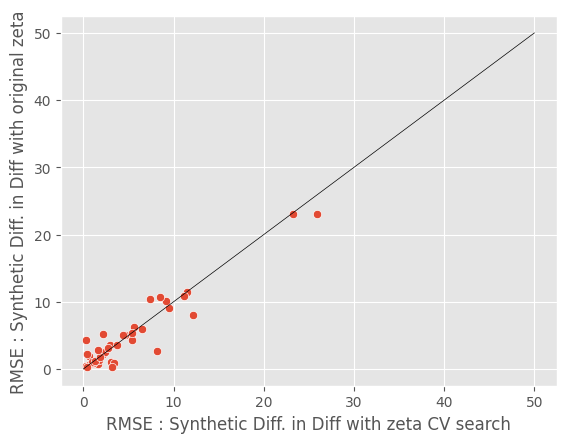

In [8]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) 
_x = np.linspace(0, 50, 30)
_y = _x
sns.scatterplot(data=result_rmse, x="sdid_bayesian_opt", y="sdid", ax = ax)
ax.plot(_x, _y, color='black',  linestyle='solid',linewidth = 0.5)
ax.set_xlabel("RMSE : Synthetic Diff. in Diff with zeta CV search")
ax.set_ylabel("RMSE : Synthetic Diff. in Diff with original zeta")
#ax.set_xlim(0, 25)
#ax.set_ylim(0, 55)
plt.show()

In [9]:
result_rmse.mean()

did                  9.436689
sc                   6.396863
sdid                 5.017344
sdid_bayesian_opt    5.095928
dtype: float64

---
## (2) Significant relaxation of ADH conditions
- The AAtest results below confirm that the original Synthetic Diff. in Diff. has better performance then sdid with Lasso, Rige, and ElasticNet
- This seems to be the assumption of the original paper. In the first place, SythDID has been developed to compensate for the shortcomings in classical SC because it concentrates on a specific donor pool and the results are not stable.
- Among the sparce regressions, the Rigge regression performed better, and the Lasso regression is similar to the classical SC, which seems to be the assumption of the original paper

In [10]:
state_list = df.columns

result_rmse_list = []

for _state in tqdm(state_list):
    _sdid = SynthDID(df, PRE_TEREM2, POST_TEREM2, [_state])
    _sdid.fit(zeta_type="base", sparce_estimation=True)

    _outcome = pd.DataFrame({"actual_y": _sdid.target_y()})

    _outcome["did"] = _sdid.did_potentical_outcome()
    _outcome["sc"] = _sdid.sc_potentical_outcome()
    _outcome["sdid"] = _sdid.sdid_potentical_outcome()
    _outcome["sdid_ElasticNet"] = _sdid.sparceReg_potentical_outcome(model="ElasticNet")
    _outcome["sdid_Lasso"] = _sdid.sparceReg_potentical_outcome(model="Lasso")
    _outcome["sdid_Ridge"] = _sdid.sparceReg_potentical_outcome(model="Ridge")
    _outcome = _outcome.loc[POST_TEREM2[0] : POST_TEREM2[1]]

    _rmse = np.sqrt((_outcome.mean() - _outcome.mean()["actual_y"]) ** 2)
    _rmse = pd.DataFrame(_rmse).T[
        ["did", "sc", "sdid", "sdid_ElasticNet", "sdid_Lasso", "sdid_Ridge"]
    ]
    _rmse.index = [_state]

    result_rmse_list.append(_rmse)
    
result_rmse = pd.concat(result_rmse_list)

100%|██████████| 39/39 [02:03<00:00,  3.16s/it]


In [11]:
result_rmse.mean()

did                9.436689
sc                 6.396863
sdid               5.017344
sdid_ElasticNet    7.483973
sdid_Lasso         6.606194
sdid_Ridge         5.696426
dtype: float64